In [95]:
import sys

from pathlib import Path
ROOT_PATH = Path.cwd().parent

# To access packages and files from root directory
sys.path.insert(1, str(ROOT_PATH))

In [96]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import time
from typing import Tuple, Type

import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import optax

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

# Local imports
import loss
import dataset_1dgp
import plotting
import model

print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {numpyro.__version__}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
JAX version: 0.3.13
Numpyro version: 0.9.2


In [97]:
numpyro.set_host_device_count(4)
print(jax.local_device_count())

4


In [98]:
def compute_ess_1dgp(mcmc_obj):
    ss = numpyro.diagnostics.summary(mcmc_obj.get_samples(group_by_chain=True))
    r = np.mean(ss['f']['n_eff'])
    print("Average ESS for all spatial effects: " + str(round(r)))

In [99]:
FIG_PATH = Path.cwd() / 'figures/1DGP_figures'
FIG_PATH.mkdir(exist_ok=True, parents=True)

PUBLICATION_PATH = FIG_PATH / '1DGP_inference'
PUBLICATION_PATH.mkdir(exist_ok=True)

DATASET_PATH = ROOT_PATH / 'dataset.nosync'
DATASET_PATH.mkdir(exist_ok=True)

MODEL_PATH = Path.cwd() / 'models'

In [100]:
RNG_SEED = 44
RNG_KEY = jax.random.PRNGKey(RNG_SEED)

In [101]:
from dataclasses import dataclass
from typing import Dict, Optional, Callable

LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

@dataclass
class GP1DArgs:
  kernel: Callable = dataset_1dgp.exp_sq_kernel
  num_locations: int = 400

GP1D_ARGS = GP1DArgs()

In [102]:
# GP priors to encode
X = jnp.arange(0, 1, 1/GP1D_ARGS.num_locations)
BASE_GRAPH = dataset_1dgp.create_1dgp_graph(GP1D_ARGS.num_locations)

# Load params

In [103]:
# VGAE+L2G
vgaeL2G_model_name = '1DGP_VGAE_L2G'
model_path = MODEL_PATH / vgaeL2G_model_name

print(f"Loading VGAE+L2G model from {model_path}")
vgaeL2G_params = model.restore_params(model_path)

# VGAE
vgaeBASE_model_name = '1DGP_VGAE_base'
model_path = MODEL_PATH / vgaeBASE_model_name

print(f"Loading VGAE-base model from {model_path}")
vgaeBASE_params = model.restore_params(model_path)

# VAE
vae_model_name = '1DGP_PriorVAE_baseline'
model_path = ROOT_PATH / 'models' / vae_model_name

print(f"Loading VAE model from {model_path}")
vae_params = model.restore_params(model_path)

Loading VGAE+L2G model from /Users/salmanfaris/Desktop/ds-projects/msc-proj/PriorVGAE/notebooks_publication/models/1DGP_VGAE_L2G
Loading VGAE-base model from /Users/salmanfaris/Desktop/ds-projects/msc-proj/PriorVGAE/notebooks_publication/models/1DGP_VGAE_base
Loading VAE model from /Users/salmanfaris/Desktop/ds-projects/msc-proj/PriorVGAE/models/1DGP_PriorVAE_baseline


# Models

In [104]:
from typing import Callable
import layer

def decoder_vgaeBASE(
        z: jnp.ndarray,
        graph: jraph.GraphsTuple,
        hidden_gnn_dim: int,
        output_dim: int,
        num_nodes: int,
        batch_size: int,
        act_fn: Callable = jax.nn.elu) -> jraph.GraphsTuple:
    
    z = hk.Linear(num_nodes*hidden_gnn_dim,
                  name='decoder_hidden2_fc')(z)  # (1, num_nodes*hidden_gnn_dim)
    z = act_fn(z)
    
    # Reshape to jraph.batch format: (num_nodes, hidden_gnn_dim)
    z = z.reshape((batch_size*num_nodes, hidden_gnn_dim))
    graph = graph._replace(nodes=z)

    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim, name='decoder_hidden_gnn1'), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Sequential([
            hk.Linear(2*hidden_gnn_dim, name='decoder_hidden_gnn2'), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    # No activation
    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Linear(output_dim, name='decoder_output'),
        add_self_edges=True,
    )
    graph = gn(graph)

    return graph

def decoder_vgaeL2G(
        z: jnp.ndarray,
        graph: jraph.GraphsTuple,
        hidden_gnn_dim: int,
        output_dim: int,
        num_nodes: int,
        batch_size: int,
        act_fn: Callable = jax.nn.elu) -> jraph.GraphsTuple:
    
    z = hk.Linear(num_nodes*hidden_gnn_dim,
                  name='decoder_hidden2_fc')(z)  # (1, num_nodes*hidden_gnn_dim)
    z = act_fn(z)
    
    # Reshape to jraph.batch format: (num_nodes, hidden_gnn_dim)
    z = z.reshape((batch_size*num_nodes, hidden_gnn_dim))
    graph = graph._replace(nodes=z)

    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_gnn_dim, name='decoder_hidden_gnn1'), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    gn = layer.GraphConvolutionSharpening(
        update_node_fn=hk.Sequential([
            hk.Linear(2*hidden_gnn_dim, name='decoder_hidden_gnn2'), act_fn,
        ]),
        add_self_edges=True,
    )
    graph = gn(graph)
    
    x = graph.nodes.reshape(batch_size, num_nodes, 2*hidden_gnn_dim)
    x = hk.Flatten()(x)  # dim: (batch_size, num_nodes*hidden_gnn_dim)

    x = hk.Linear(num_nodes, name='decoder_output')(x)
    # graph = graph._replace(nodes=x.T)

    # return graph
    return jnp.reshape(x, (batch_size*num_nodes, 1))

# Inference predictives

In [105]:
# VAE settings
vae_hidden1_dim = 30
vae_hidden2_dim = 35
vae_latent_dim = 10

vae_decoder_params_keys = [k for k in list(vae_params.keys()) if k.startswith('variational_auto_encoder/decoder')]
vae_decoder_params = {}
for full_key_name in vae_decoder_params_keys:
    key_name = ('/').join(full_key_name.split('/')[2:])  # remove the 'variational_auto_encoder/' prefix
    vae_decoder_params[key_name] = vae_params[full_key_name]

vae_decoder_net = hk.without_apply_rng(
    hk.transform(  
      lambda z: model.priorvae_decoder(
        z,
        hidden1_dim=vae_hidden1_dim,
        hidden2_dim=vae_hidden2_dim,
        output_dim=GP1D_ARGS.num_locations
    )
))

def vae_predictive_model(y=None, obs_idx=None):
    z = numpyro.sample('z', dist.Normal(0, 1).expand([vae_latent_dim]))
    vae_out = jnp.squeeze(vae_decoder_net.apply(vae_decoder_params, z))
    f = numpyro.deterministic('f', vae_out)
    sigma = numpyro.sample('noise', dist.HalfNormal(0.1))

    if y is None: # at prediction time
        numpyro.sample('y_pred', dist.Normal(f, sigma))
    else: # at inference time
        numpyro.sample('y', dist.Normal(f[obs_idx], sigma), obs=y)

In [106]:
from functools import partial

# VGAE settings
vgae_latent_dim = 10
vgae_hidden_dim = 6

# VGAE+L2G
vgaeL2G_decoder_keys = [k for k in list(vgaeL2G_params.keys()) if k.startswith('vgae/decoder')]
vgaeL2G_decoder = {}
for full_key_name in vgaeL2G_decoder_keys:
    key_name = full_key_name.split('/')[-1]  # remove the 'vgae/' prefix
    vgaeL2G_decoder[key_name] = vgaeL2G_params[full_key_name]

vgaeL2G_decoder_net_fn = partial(decoder_vgaeL2G,
                         graph=BASE_GRAPH,
                         hidden_gnn_dim=vgae_hidden_dim,
                         output_dim=GP1D_ARGS.num_locations,
                         batch_size=1,
                         num_nodes=GP1D_ARGS.num_locations)
vgaeL2G_decoder_net = hk.without_apply_rng(hk.transform(vgaeL2G_decoder_net_fn))

def vgaeL2G_predictive_model(y=None, obs_idx=None):
    z = numpyro.sample('z', dist.Normal(0, 1).expand([vgae_latent_dim]))
    vgae_out = jnp.squeeze(vgaeL2G_decoder_net.apply(vgaeL2G_decoder, z))
    f = numpyro.deterministic('f', vgae_out)
    sigma = numpyro.sample('noise', dist.HalfNormal(0.1))

    if y is None: # at prediction time
        numpyro.sample('y_pred', dist.Normal(f, sigma))
    else: # at inference time
        numpyro.sample('y', dist.Normal(f[obs_idx], sigma), obs=y)
        
        
# # Base VGAE
# vgaeBASE_decoder_keys = [k for k in list(vgaeBASE_params.keys()) if k.startswith('vgae/decoder')]
# vgaeBASE_decoder = {}
# for full_key_name in vgaeBASE_decoder_keys:
#     key_name = full_key_name.split('/')[-1]  # remove the 'vgae/' prefix
#     vgaeBASE_decoder[key_name] = vgaeBASE_params[full_key_name]

# vgaeBASE_decoder_net_fn = partial(decoder_vgaeBASE,
#                          graph=BASE_GRAPH,
#                          hidden_gnn_dim=vgae_hidden_dim,
#                          output_dim=1,
#                          batch_size=1,
#                          num_nodes=GP1D_ARGS.num_locations)
# vgaeBASE_decoder_net = hk.without_apply_rng(hk.transform(vgaeBASE_decoder_net_fn))

# def vgaeBASE_predictive_model(y=None, obs_idx=None):
#     z = numpyro.sample('z', dist.Normal(0, 1).expand([vgae_latent_dim]))
#     vgae_out = jnp.squeeze(vgaeBASE_decoder_net.apply(vgaeBASE_decoder, z).nodes)
#     f = numpyro.deterministic('f', vgae_out)
#     sigma = numpyro.sample('noise', dist.HalfNormal(0.1))

#     if y is None: # at prediction time
#         numpyro.sample('y_pred', dist.Normal(f, sigma))
#     else: # at inference time
#         numpyro.sample('y', dist.Normal(f[obs_idx], sigma), obs=y)

# Begin inference

In [107]:
# RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(10))  # THIS WAS OUR CHOICE
# RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(21))

RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(22))

# RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(8))
# RNG_KEY, gp_rng = jax.random.split(jax.random.PRNGKey(6))
# RNG_KEY, gp_rng = jax.random.split(RNG_KEY)

# Generate true data and observed dataset to infer
draws = Predictive(dataset_1dgp.gp_predictive_model, num_samples=1)(
  gp_rng, x=X, gp_kernel=GP1D_ARGS.kernel, noise=True)
gp_draw = draws['f'].T  # True data
y_draw = draws['y'].T  # True data + noise

assert not jnp.isnan(y_draw).any(), 'NaNs in y_draw'

# Choose indices of datapoints for inference.
obs_locations = [
  jnp.array([137, 321]),  # 2 observed datapoints [134, 321] works but that's because PriorVAE fcked up
  jnp.array([89, 133, 296, 370]),  # 4 observed datapoints
  jnp.array([71, 85, 137, 275, 314, 380]),  # 6 observed datapoints
]
# obs_locations = [
#   jnp.array([122, 321]),  # 2 observed datapoints
#   jnp.array([126, 133, 296, 370]),  # 4 observed datapoints
#   jnp.array([41, 85, 137, 275, 314, 380]),  # 6 observed datapoints
# ]

x_obs = X[obs_locations[-1]]
y_obs = jnp.squeeze(y_draw[obs_locations[-1]])

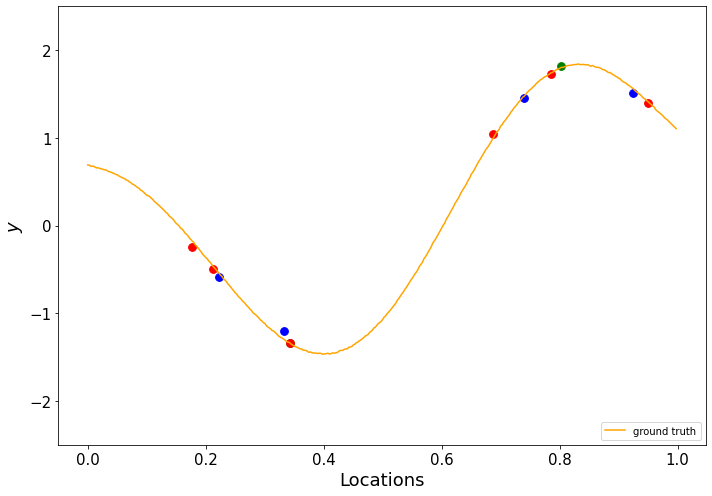

In [108]:
# Plotting VAE posterior predictive
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.plot(X, gp_draw, label='ground truth', color='orange')
# ax.set_title('n_datapoints = ' + str(len(obs_locations[idx])))

ax.legend(loc=4)
ax.set_ylim([-2.5, 2.5])

ax.set_xlabel('Locations', fontsize=18)
ax.set_ylabel(r'$y$', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.scatter(X[obs_locations[0]], jnp.squeeze(y_draw[obs_locations[0]]), color='green', label='observed data', s=60)
ax.scatter(X[obs_locations[1]], jnp.squeeze(y_draw[obs_locations[1]]), color='blue', label='observed data', s=60)
ax.scatter(X[obs_locations[2]], jnp.squeeze(y_draw[obs_locations[2]]), color='red', label='observed data', s=60)

plt.tight_layout()
plt.show()

# fig.savefig(PUBLICATION_PATH / f'1DGP_inference_00.jpg', dpi=300)

In [109]:
vgaeL2G_mean_post_preds_list = []
vgaeL2G_hpdi_post_preds_list = []
obs_xs = []
obs_ys = []
vgaeL2G_predictions_list = []
vgaeL2G_mcmc_objs = []

RNG_KEY, inference_rng = jax.random.split(RNG_KEY)

for i, obs_location in enumerate(obs_locations):
    mcmc_rng, pred_rng = jax.random.split(jax.random.fold_in(inference_rng, i))
    
    x_obs = X[obs_location]
    y_obs = jnp.squeeze(y_draw[obs_location])
    
    print(f'Running chain for n_obs = {len(obs_location)}')
    
    # MCMC sampling
    start = time.time()
    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(vgaeL2G_predictive_model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=1000,
        num_chains=4,
        thinning=1,
        progress_bar=False if 'NUMPYRO_SPHINXBUILD' in os.environ else True,
    )
    mcmc.run(mcmc_rng, y_obs, obs_location)
    print('\nMCMC elapsed time:', time.time() - start)
    
    mcmc_samples = mcmc.get_samples()
    vgaeL2G_mcmc_objs.append(mcmc)

    predictions = Predictive(vgaeL2G_predictive_model, mcmc_samples)(pred_rng)['f']
    mean_post_pred = jnp.mean(predictions, axis=0)
    hpdi_post_pred = hpdi(predictions, 0.9)
    
    obs_xs.append(x_obs)
    obs_ys.append(y_obs)
    vgaeL2G_predictions_list.append(predictions)
    vgaeL2G_mean_post_preds_list.append(mean_post_pred)
    vgaeL2G_hpdi_post_preds_list.append(hpdi_post_pred)

Running chain for n_obs = 2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 63.80701804161072
Running chain for n_obs = 4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 35.58555889129639
Running chain for n_obs = 6


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 46.70546889305115


In [110]:
vae_mean_post_preds_list = []
vae_hpdi_post_preds_list = []
obs_xs = []
obs_ys = []
vae_predictions_list = []
vae_mcmc_objs = []

RNG_KEY, inference_rng = jax.random.split(RNG_KEY)

for i, obs_location in enumerate(obs_locations):
    mcmc_rng, pred_rng = jax.random.split(jax.random.fold_in(inference_rng, i))
    
    x_obs = X[obs_location]
    y_obs = jnp.squeeze(y_draw[obs_location])
    
    print(f'Running chain for n_obs = {len(obs_location)}')
    
    # MCMC sampling
    start = time.time()
    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(vae_predictive_model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=1000,
        num_chains=4,
        thinning=1,
        progress_bar=False if 'NUMPYRO_SPHINXBUILD' in os.environ else True,
    )
    mcmc.run(mcmc_rng, y_obs, obs_location)
    print('\nMCMC elapsed time:', time.time() - start)
    
    mcmc_samples = mcmc.get_samples()
    vae_mcmc_objs.append(mcmc)

    predictions = Predictive(vae_predictive_model, mcmc_samples)(pred_rng)['f']
    mean_post_pred = jnp.mean(predictions, axis=0)
    hpdi_post_pred = hpdi(predictions, 0.9)
    
    obs_xs.append(x_obs)
    obs_ys.append(y_obs)
    vae_predictions_list.append(predictions)
    vae_mean_post_preds_list.append(mean_post_pred)
    vae_hpdi_post_preds_list.append(hpdi_post_pred)

Running chain for n_obs = 2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 3.0358641147613525
Running chain for n_obs = 4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 2.765612840652466
Running chain for n_obs = 6


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


MCMC elapsed time: 3.0148239135742188


In [111]:
print()
print('VGAEL2G')
for mcmc in vgaeL2G_mcmc_objs:
    compute_ess_1dgp(mcmc)

# print()
# print('VGAEBASE')
# for mcmc in vgaeBASE_mcmc_objs:
#     compute_ess_1dgp(mcmc)

print()
print('VAE')
for mcmc in vae_mcmc_objs:
    compute_ess_1dgp(mcmc)



VGAEL2G
Average ESS for all spatial effects: 1541
Average ESS for all spatial effects: 1539
Average ESS for all spatial effects: 1793

VAE
Average ESS for all spatial effects: 1984
Average ESS for all spatial effects: 1503
Average ESS for all spatial effects: 1721


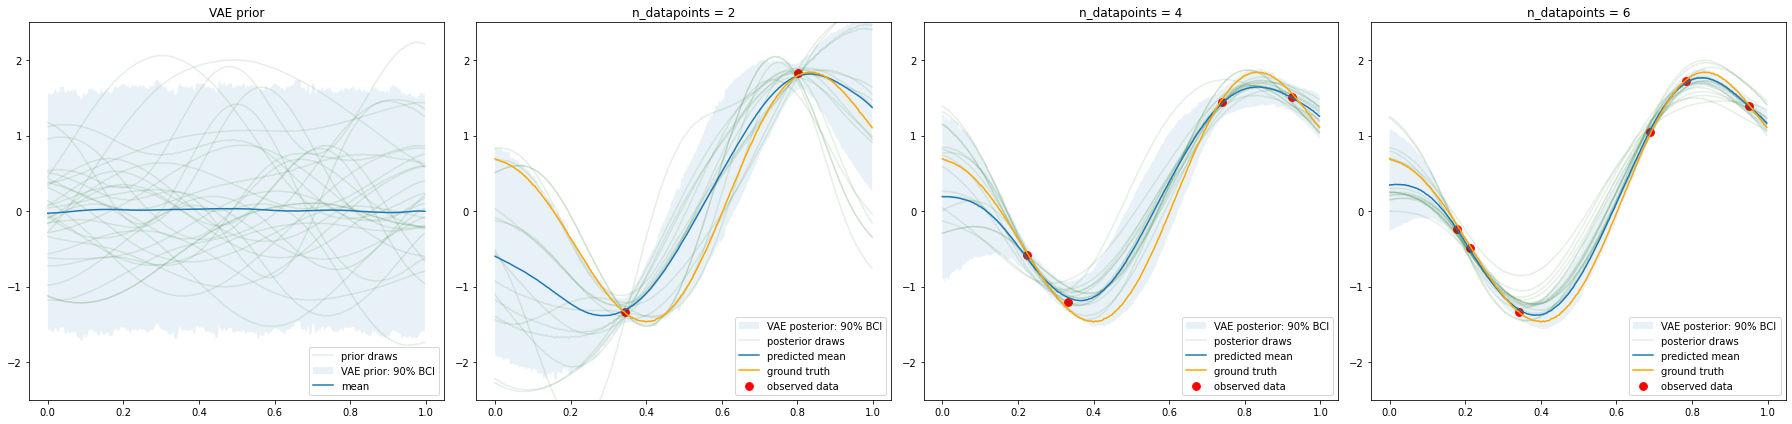

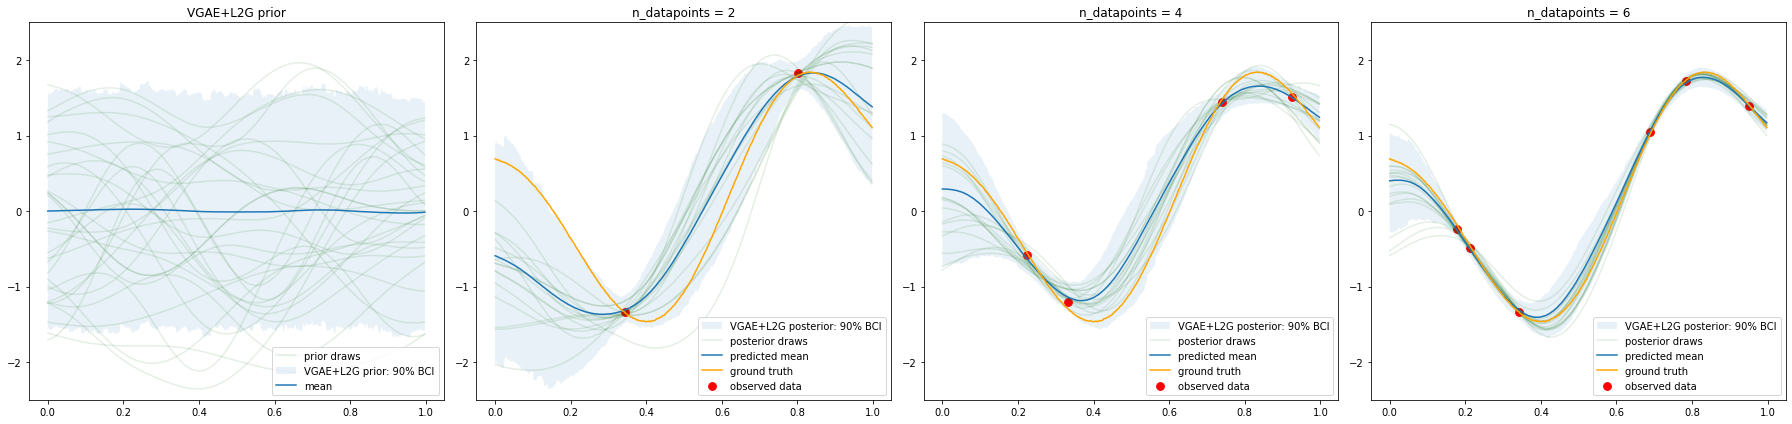

In [112]:
# VAE results
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

# Plotting VAE prior predictive.
RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
vae_prior_predictions = Predictive(vae_predictive_model, num_samples=10000)(prior_rng)['f']
vae_mean_prior_pred = jnp.mean(vae_prior_predictions, axis=0)
vae_hpdi_prior_pred = hpdi(vae_prior_predictions, 0.9)

num_draws_to_plot = 30
for j in range(num_draws_to_plot):
    axes[0].plot(X, vae_prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, vae_prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, vae_hpdi_prior_pred[0], vae_hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VAE prior: 90% BCI')
axes[0].plot(X, vae_mean_prior_pred, label='mean')
axes[0].set_title('VAE prior')


# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, vae_hpdi_post_preds_list[idx][0], vae_hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 90% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, vae_predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, vae_predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, vae_mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

# >>>>>>>>>>>>>>>>
# VGAE+L2G results
_, axes = plt.subplots(nrows=1, ncols=len(obs_locations)+1, figsize=(25,6))

RNG_KEY, prior_rng = jax.random.split(RNG_KEY)
vgaeL2G_prior_predictions = Predictive(vgaeL2G_predictive_model, num_samples=10000)(prior_rng)['f']
vgaeL2G_mean_prior_pred = jnp.mean(vgaeL2G_prior_predictions, axis=0)
vgaeL2G_hpdi_prior_pred = hpdi(vgaeL2G_prior_predictions, 0.9)

num_draws_to_plot = 30
for j in range(num_draws_to_plot):
    axes[0].plot(X, vgaeL2G_prior_predictions[j], alpha=0.1, color='darkgreen')
axes[0].plot(X, vgaeL2G_prior_predictions[0], 
             alpha=0.1, color='darkgreen', label='prior draws')  
axes[0].fill_between(X, vgaeL2G_hpdi_prior_pred[0], vgaeL2G_hpdi_prior_pred[1], 
                     alpha=0.1, interpolate=True, label='VGAE+L2G prior: 90% BCI')
axes[0].plot(X, vgaeL2G_mean_prior_pred, label='mean')
axes[0].set_title('VGAE+L2G prior')


# Plotting VGAE+L2G posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    axes[idx+1].fill_between(X, vgaeL2G_hpdi_post_preds_list[idx][0], vgaeL2G_hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VGAE+L2G posterior: 90% BCI')
    for j in range(num_draws_to_plot): 
        axes[idx+1].plot(X, vgaeL2G_predictions_list[idx][j], alpha=0.1, color='darkgreen')
    axes[idx+1].plot(X, vgaeL2G_predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws')  
    axes[idx+1].plot(X, vgaeL2G_mean_post_preds_list[idx], label='predicted mean')
    axes[idx+1].plot(X, gp_draw, label='ground truth', color='orange')
    axes[idx+1].scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=60)
    axes[idx+1].set_title('n_datapoints = ' + str(len(obs_locations[idx])))


for i in range(len(obs_locations)+1):    
    axes[i].legend(loc=4)
    axes[i].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

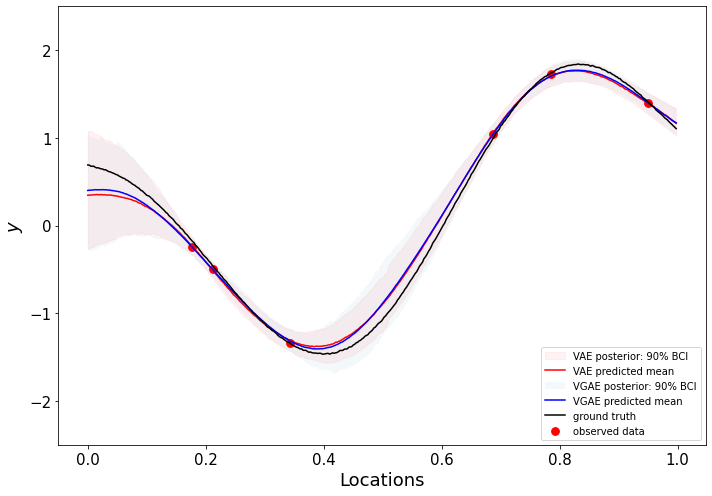

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.fill_between(X, vae_hpdi_post_preds_list[-1][0], vae_hpdi_post_preds_list[-1][1], 
                        alpha=0.05, interpolate=True, label='VAE posterior: 90% BCI', color='red')
ax.plot(X, vae_mean_post_preds_list[-1], label='VAE predicted mean', color='red')

ax.fill_between(X, vgaeL2G_hpdi_post_preds_list[-1][0], vgaeL2G_hpdi_post_preds_list[-1][1], 
                        alpha=0.05, interpolate=True, label='VGAE posterior: 90% BCI')
ax.plot(X, vgaeL2G_mean_post_preds_list[-1], label='VGAE predicted mean', color='blue')


ax.plot(X, gp_draw, label='ground truth', color='black')
ax.scatter(obs_xs[-1], obs_ys[-1], color='red', label='observed data', s=60)
# ax.set_title('n_datapoints = ' + str(len(obs_locations[-1])))

ax.legend(loc=4)
ax.set_ylim([-2.5, 2.5])

ax.set_xlabel('Locations', fontsize=18)
ax.set_ylabel(r'$y$', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()

# fig.savefig(PUBLICATION_PATH / f'1DGP_inference_VGAE_{idx+2}.jpg', dpi=300)

In [114]:
mse_vgaes = []
mse_vaes = []

for idx, mean in enumerate(vgaeL2G_mean_post_preds_list):
    mse_vgae = np.mean((gp_draw.flatten() -  mean)**2)
    print(f'mse_vgaeL2G ({len(obs_locations[idx])}) = {mse_vgae}')
    mse_vgaes.append(mse_vgae)

# print()
# for idx, mean in enumerate(vgaeBASE_mean_post_preds_list):
#     mse_vgae = np.mean((gp_draw.flatten() -  mean)**2)
#     print(f'mse_vgae ({len(obs_locations[idx])}) = {mse_vgae}')

print()
for idx, mean in enumerate(vae_mean_post_preds_list):
    mse_vae = np.mean((gp_draw.flatten() -  mean)**2)
    print(f'mse_vae ({len(obs_locations[idx])}) = {mse_vae}')
    mse_vaes.append(mse_vae)

mse_vgaeL2G (2) = 0.40928539633750916
mse_vgaeL2G (4) = 0.0745651125907898
mse_vgaeL2G (6) = 0.011357368901371956

mse_vae (2) = 0.4211541712284088
mse_vae (4) = 0.08170578628778458
mse_vae (6) = 0.013786754570901394


In [115]:
print(vgaeL2G_hpdi_post_preds_list[-1][0].mean())
print(vgaeL2G_hpdi_post_preds_list[-1][1].mean())

print()

print(vae_hpdi_post_preds_list[-1][0].mean())
print(vae_hpdi_post_preds_list[-1][1].mean())

-0.03418148
0.41538247

-0.0059298323
0.39451644


In [116]:
mse_vgaes = np.array(mse_vgaes) * 100
mse_vaes = np.array(mse_vaes) * 100

np.abs(mse_vgaes - mse_vaes) / mse_vaes * 100

array([ 2.818156,  8.739497, 17.621153], dtype=float32)

In [117]:
mse_vgaes

array([40.92854  ,  7.4565115,  1.135737 ], dtype=float32)

In [118]:
np.abs(mse_vgaes - mse_vaes)

array([1.1868782 , 0.71406746, 0.24293852], dtype=float32)

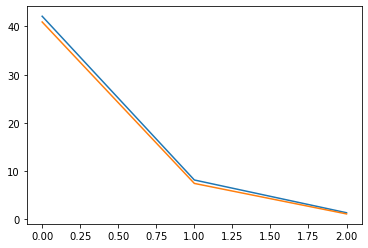

In [119]:
plt.plot(mse_vaes)
plt.plot(mse_vgaes)

In [120]:
print(RNG_KEY)

[2914599481 3408122042]


# Publication plots

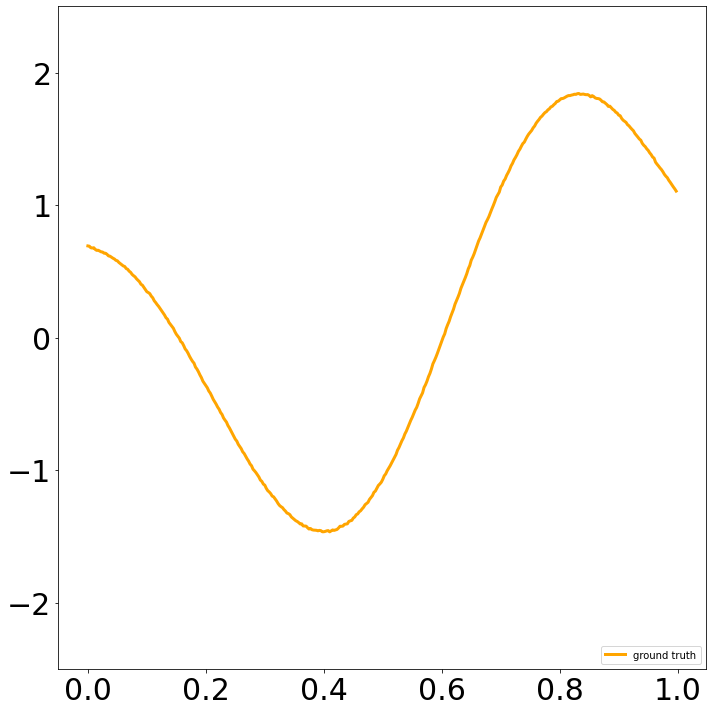

In [121]:
# Plotting VAE posterior predictive
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(X, gp_draw, label='ground truth', color='orange', linewidth=3)
# ax.set_title('n_datapoints = ' + str(len(obs_locations[idx])))

ax.legend(loc=4)
ax.set_ylim([-2.5, 2.5])

# ax.set_xlabel('Locations', fontsize=18)
# ax.set_ylabel(r'$y$', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()
plt.show()

fig.savefig(PUBLICATION_PATH / f'1DGP_inference_00.jpg', dpi=300)

## PriorVGAE plots

n_datapoints = 2


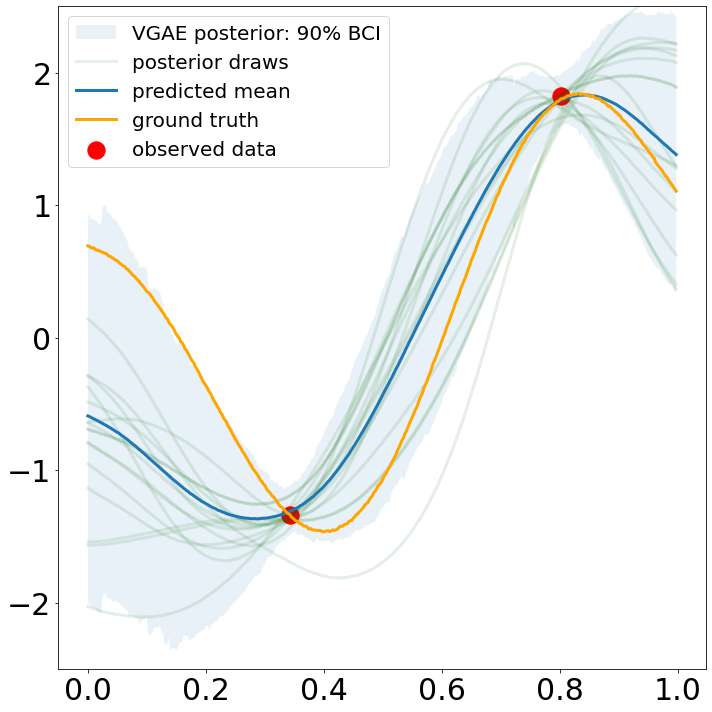

n_datapoints = 4


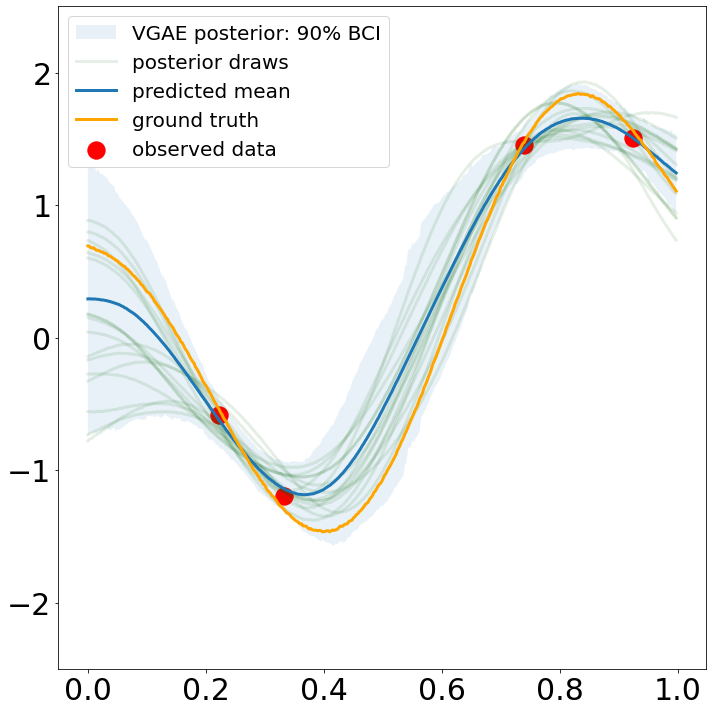

n_datapoints = 6


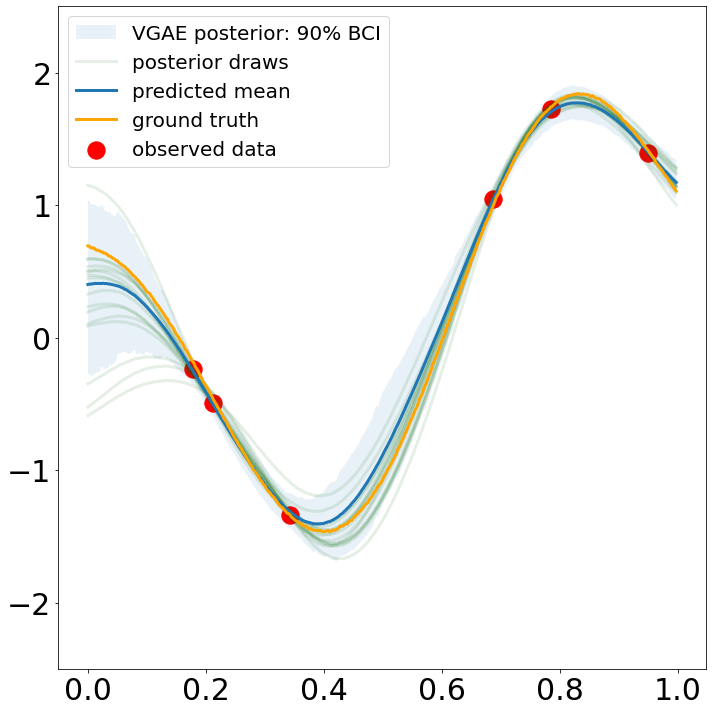

In [122]:
# Plotting VGAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    print(f'n_datapoints = {len(obs_locations[idx])}')
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    ax.fill_between(X, vgaeL2G_hpdi_post_preds_list[idx][0], vgaeL2G_hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VGAE posterior: 90% BCI', linewidth=3)
    for j in range(num_draws_to_plot): 
        ax.plot(X, vgaeL2G_predictions_list[idx][j], alpha=0.1, color='darkgreen', linewidth=3)
    ax.plot(X, vgaeL2G_predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws', linewidth=3)
    ax.plot(X, vgaeL2G_mean_post_preds_list[idx], label='predicted mean', linewidth=3)
    ax.plot(X, gp_draw, label='ground truth', color='orange', linewidth=3)
    ax.scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=300)
    # ax.set_title('n_datapoints = ' + str(len(obs_locations[idx])))
    
    ax.legend(loc=4)
    ax.set_ylim([-2.5, 2.5])
    
    # ax.set_xlabel('Locations', fontsize=18)
    # ax.set_ylabel(r'$y$', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=30)
    
    plt.legend(fontsize=20, loc='upper left')
    plt.tight_layout()
    plt.show()
    
    fig.savefig(PUBLICATION_PATH / f'1DGP_inference_VGAE_{idx+2}.jpg', dpi=300)

## PriorVAE plots

In [123]:
PUBLICATION_PATH

PosixPath('/Users/salmanfaris/Desktop/ds-projects/msc-proj/PriorVGAE/notebooks_publication/figures/1DGP_figures/1DGP_inference')

n_datapoints = 2


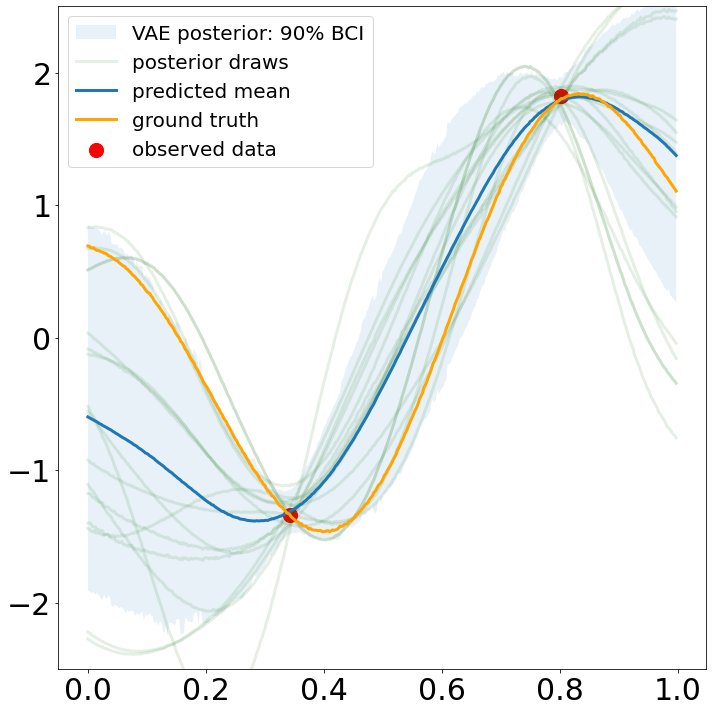

n_datapoints = 4


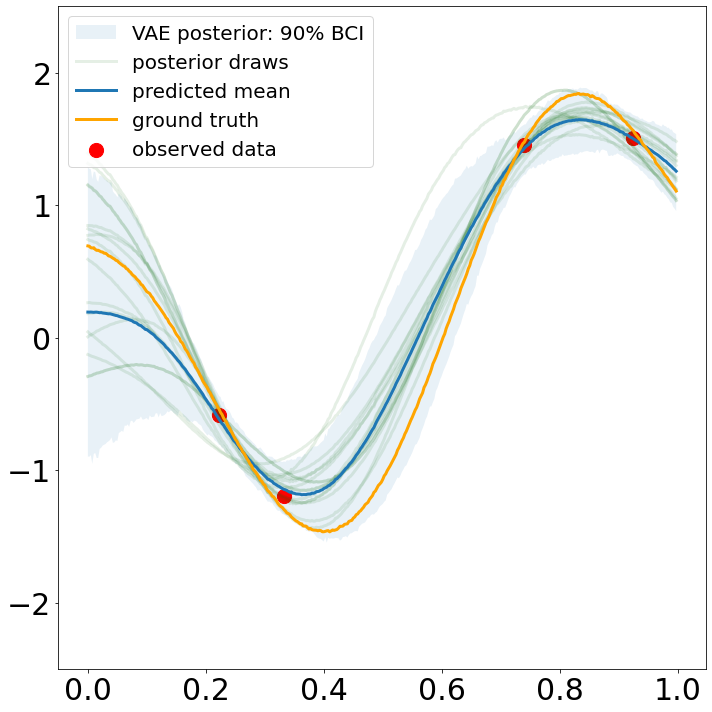

n_datapoints = 6


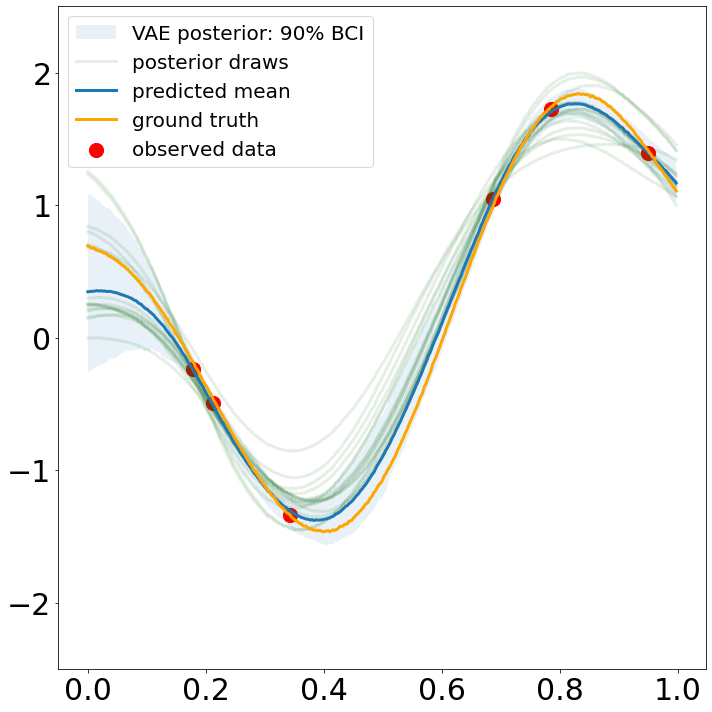

In [124]:
# Plotting VAE posterior predictive
num_draws_to_plot = 15
for idx in range(len(obs_locations)):
    print(f'n_datapoints = {len(obs_locations[idx])}')
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    ax.fill_between(X, vae_hpdi_post_preds_list[idx][0], vae_hpdi_post_preds_list[idx][1], 
                           alpha=0.1, interpolate=True, label='VAE posterior: 90% BCI', linewidth=3)
    for j in range(num_draws_to_plot): 
        ax.plot(X, vae_predictions_list[idx][j], alpha=0.1, color='darkgreen', linewidth=3)
    ax.plot(X, vae_predictions_list[idx][0],
                   alpha=0.1, color='darkgreen', label='posterior draws', linewidth=3)
    ax.plot(X, vae_mean_post_preds_list[idx], label='predicted mean', linewidth=3)
    ax.plot(X, gp_draw, label='ground truth', color='orange', linewidth=3)
    ax.scatter(obs_xs[idx], obs_ys[idx], color='red', label='observed data', s=200)
    # ax.set_title('n_datapoints = ' + str(len(obs_locations[idx])))
    
    ax.legend(loc=4)
    ax.set_ylim([-2.5, 2.5])
    
    # ax.set_xlabel('Locations', fontsize=18)
    # ax.set_ylabel(r'$y$', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=30)
    
    plt.legend(fontsize=20, loc='upper left')
    plt.tight_layout()
    plt.show()
    
    fig.savefig(PUBLICATION_PATH / f'1DGP_inference_PriorVAE_{idx+2}.jpg', dpi=300)

In [125]:
print(RNG_KEY)

[2914599481 3408122042]


# Covariance plots

In [136]:
# RNG_KEY, gp_rng, vgae_rng, vae_rng = jax.random.split(jax.random.PRNGKey(1), 4)  # NEED 1000 samples

RNG_KEY, gp_rng, vgae_rng, vae_rng = jax.random.split(jax.random.PRNGKey(1), 4)

num_samples = 1000

# GP
gp_predictive = Predictive(dataset_1dgp.gp_predictive_model, num_samples=num_samples)
gp_draws = gp_predictive(gp_rng, x=X, gp_kernel=GP1D_ARGS.kernel, kernel_jitter=1e-5)['y']
gp_draws = dataset_1dgp.remove_nans_from_gp(gp_draws)

# VGAE
vgae_predictive = Predictive(vgaeL2G_predictive_model, num_samples=num_samples)
vgae_draws = vgae_predictive(vgae_rng)['f']
vgae_draws = dataset_1dgp.remove_nans_from_gp(vgae_draws)

# VAE
vae_predictive = Predictive(vae_predictive_model, num_samples=num_samples)
vae_draws = vae_predictive(vae_rng)['f']
vae_draws = dataset_1dgp.remove_nans_from_gp(vae_draws)

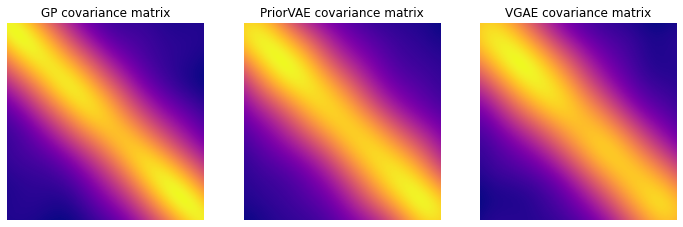

In [137]:
m_vgae = np.cov(np.transpose(vgae_draws))
m_vae = np.cov(np.transpose(vae_draws))
m_gp = np.cov(np.transpose(gp_draws))

cmap_choice = 'plasma'

#'plasma'
#'inferno'
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axs[0].imshow(m_gp, cmap=cmap_choice)
axs[0].axis('off')
axs[0].set_title('GP covariance matrix')

axs[1].imshow(m_vae, cmap=cmap_choice)
axs[1].axis('off')
axs[1].set_title('PriorVAE covariance matrix')

axs[2].imshow(m_vgae, cmap=cmap_choice)
axs[2].axis('off')
axs[2].set_title('VGAE covariance matrix')

fig.savefig(PUBLICATION_PATH / f'1DGP_covariance_matrix.jpg', dpi=300, bbox_inches='tight')

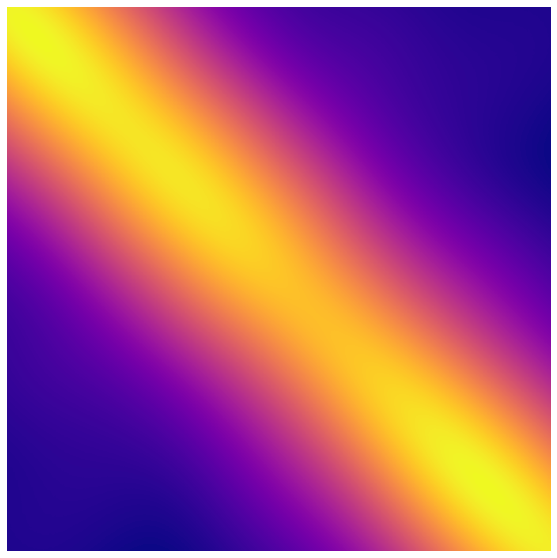

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(m_gp, cmap=cmap_choice)
ax.axis('off')
# ax.set_title('GP covariance matrix')

fig.savefig(PUBLICATION_PATH / f'1DGP_GP_covariance_matrix.jpg', dpi=300, bbox_inches='tight')

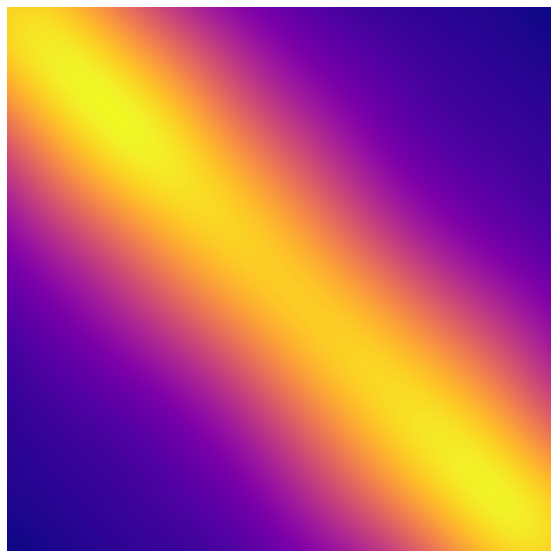

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(m_vae, cmap=cmap_choice)
ax.axis('off')
# ax.set_title('GP covariance matrix')

fig.savefig(PUBLICATION_PATH / f'1DGP_PriorVAE_covariance_matrix.jpg', dpi=300, bbox_inches='tight')

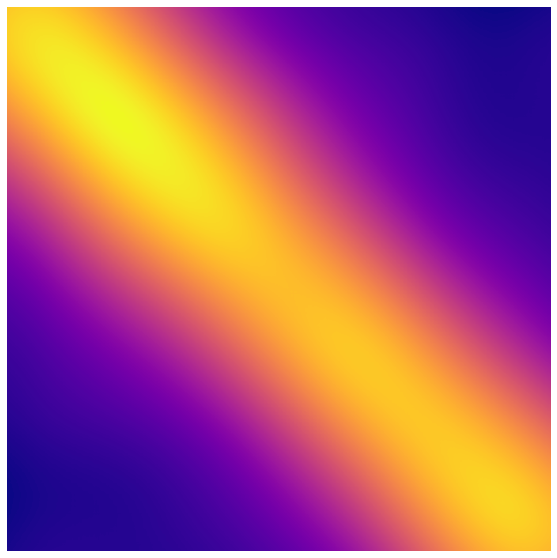

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(m_vgae, cmap=cmap_choice)
ax.axis('off')
# ax.set_title('GP covariance matrix')

fig.savefig(PUBLICATION_PATH / f'1DGP_VGAE_covariance_matrix.jpg', dpi=300, bbox_inches='tight')

# Priors shape plots

In [141]:
# Comparing distribution of GP draws with learnt VGAE priors.
RNG_KEY = jax.random.PRNGKey(4)

RNG_KEY, gp_rng, vgae_rng, vae_rng = jax.random.split(RNG_KEY, 4)

num_samples = 1000
gp_draws = dataset_1dgp.generate_gp_batch(gp_rng, X, 
                                          batch_size=num_samples, 
                                          kernel=GP1D_ARGS.kernel)
vgae_draws = Predictive(vgaeL2G_predictive_model, num_samples=num_samples)(vgae_rng)['f']
vgae_draws = vgae_draws[:,:400]

vae_draws = Predictive(vae_predictive_model, num_samples=num_samples)(vae_rng)['f']
vae_draws = vae_draws[:,:400]

# Computing the mean and HPDI of the GP draws and VGAE draws.
gp_draws = gp_draws[~np.isnan(gp_draws).any(axis=1), :]
mean_gp = jnp.nanmean(gp_draws, axis=0)
hpdi_gp = hpdi(gp_draws, 0.9)

vgae_draws = vgae_draws[~np.isnan(vgae_draws).any(axis=1), :]
mean_vgae = jnp.nanmean(vgae_draws, axis=0)
hpdi_vgae = hpdi(vgae_draws, 0.9)

vae_draws = vae_draws[~np.isnan(vae_draws).any(axis=1), :]
mean_vae = jnp.nanmean(vae_draws, axis=0)
hpdi_vae = hpdi(vae_draws, 0.9)

In [142]:
linewidth = 3

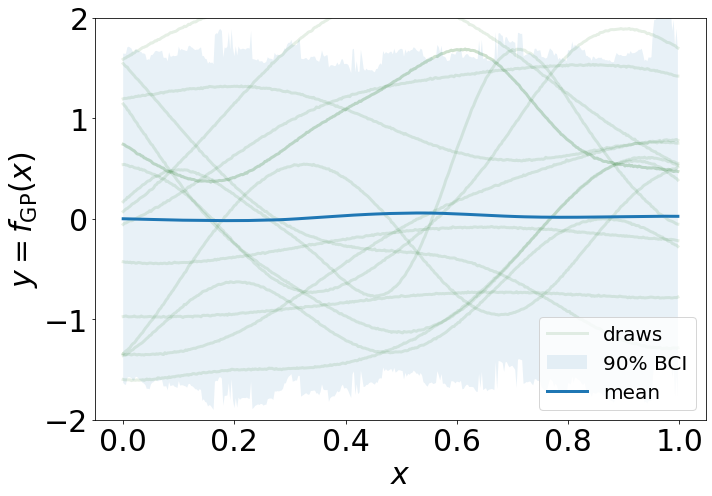

In [143]:
# Plotting the GP draws.
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

y_lim = [-2, 2]
lines_alpha_gp = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, gp_draws, 
    mean_gp, hpdi_gp,lines_alpha_gp, 
    num_draws_to_plot, y_lim=y_lim, ax=ax, linewidth=linewidth)

# ax.set_title('GP priors to be learnt', fontsize=18)
ax.set_ylabel('$y=f_{\mathrm{GP}}(x)$', fontsize=30)
ax.set_xlabel('$x$', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=30)
    
plt.legend(fontsize=20, loc='lower right')

plt.tight_layout()
plt.show()

fig.savefig(PUBLICATION_PATH / '1DGP_priors_GP.jpg', dpi=300)

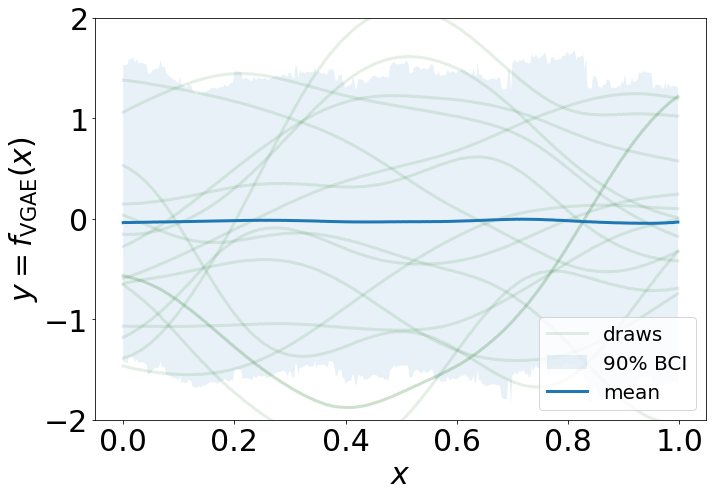

In [144]:
# Plotting the GP draws and VGAE draws.
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

y_lim = [-2, 2]
lines_alpha_vgae = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, vgae_draws, 
    mean_vgae, hpdi_vgae,lines_alpha_vgae, 
    num_draws_to_plot, y_lim=y_lim, ax=ax, linewidth=linewidth)

# ax.set_title('Priors learnt by VGAE', fontsize=18)
ax.set_ylabel('$y=f_{\mathrm{VGAE}}(x)$', fontsize=30)
ax.set_xlabel('$x$', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=30)
    
plt.legend(fontsize=20, loc='lower right')

plt.tight_layout()
plt.show()

fig.savefig(PUBLICATION_PATH / '1DGP_priors_VGAE.jpg', dpi=300)

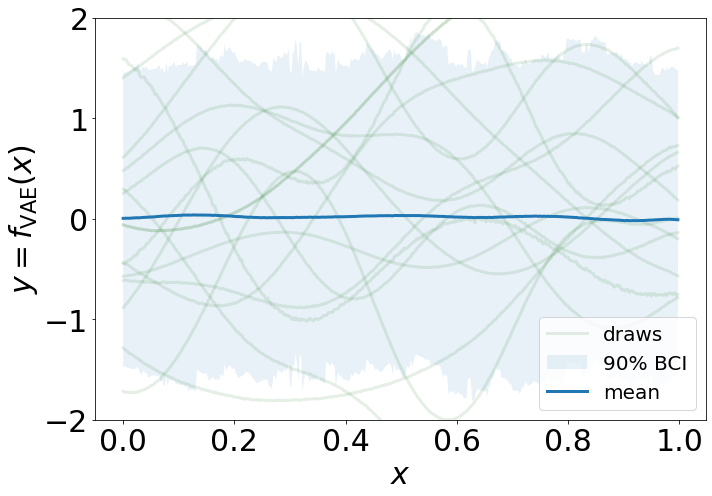

In [145]:
# Plotting the GP draws and VAE draws.
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

y_lim = [-2, 2]
lines_alpha_vae = 0.1
num_draws_to_plot = 15
plotting.plot_gp_draws_with_stats(
    X, vae_draws, 
    mean_vae, hpdi_vae,lines_alpha_vae, 
    num_draws_to_plot, y_lim=y_lim, ax=ax, linewidth=linewidth)

# ax.set_title('Priors learnt by VAE', fontsize=18)
ax.set_ylabel('$y=f_{\mathrm{VAE}}(x)$', fontsize=30)
ax.set_xlabel('$x$', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=30)
    
plt.legend(fontsize=20, loc='lower right')

plt.tight_layout()
plt.show()

fig.savefig(PUBLICATION_PATH / '1DGP_priors_VAE.jpg', dpi=300)